训练并导出LSTM模型

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch as torch
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
print(torch.__version__)
# torch.set_num_threads(6)

2.0.1


In [2]:
device = torch.device("cpu")
os.environ["KMP_DUPLICATE_LIB_OK"] = "1"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [3]:
df = pd.read_csv("../datasets/mfp/train_data.csv", dtype={'v': np.float32}, index_col='t', parse_dates=True)
print(type(df[['v']].iloc[0].values[0]))

<class 'numpy.float32'>


## 查看原始数据

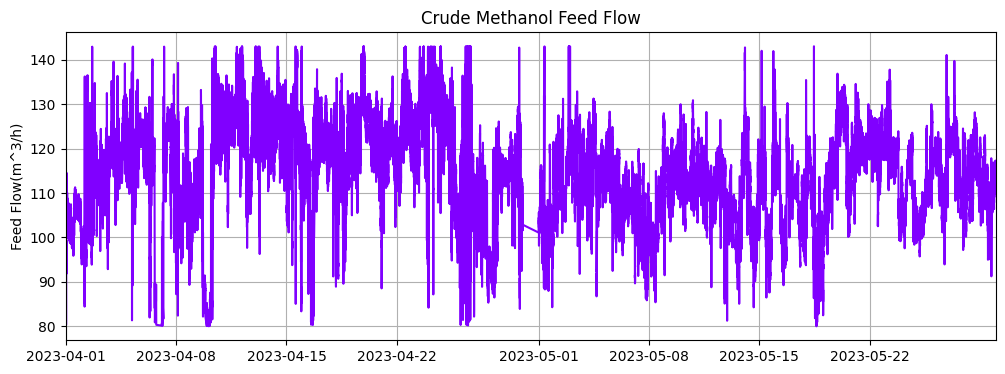

In [4]:
plt.figure(figsize=(12, 4))
plt.title('Crude Methanol Feed Flow')
plt.ylabel('Feed Flow(m^3/h)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['v'], color='#8000ff')
plt.show()

In [5]:
# 准备数据

In [6]:
df.dropna()
train_set = df.values.astype(float)

In [7]:
train_set


array([[100.21099854],
       [100.99099731],
       [101.73100281],
       ...,
       [115.66799927],
       [114.8030014 ],
       [117.05200195]])

# 归一化处理

In [8]:
from torch.autograd import Variable


def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)


sc = MinMaxScaler()
training_data = sc.fit_transform(train_set)  # 定义一个最小-最大标准化器，用于将数据进行归一化
seq_length = 20  # 定义滑动窗口的长度，这里为 1，即不使用滑动窗口
x, y = sliding_windows(training_data, seq_length)  # 将归一化后的数据转换为滑动窗口数据

train_size = int(len(y) * 0.6)
test_size = len(y) - train_size

dataX = Variable(torch.tensor(np.array(x), dtype=torch.float32, device=device))
dataY = Variable(torch.tensor(np.array(y), dtype=torch.float32, device=device))

trainX = Variable(torch.tensor(np.array(x[0:train_size]), dtype=torch.float32, device=device))
trainY = Variable(torch.tensor(np.array(y[0:train_size]), dtype=torch.float32, device=device))
testX = Variable(torch.tensor(np.array(x[train_size:len(x)]), dtype=torch.float32, device=device))
testY = Variable(torch.tensor(np.array(y[train_size:len(y)]), dtype=torch.float32, device=device))

# 定义模型

In [9]:
from torch import nn


class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        """

        :param num_classes: 预测目标的类别数
        :param input_size: LSTM层数
        :param hidden_size: 隐藏层维度
        :param num_layers: 输入层维度
        """
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, device=device)
        # 定义全连接层
        self.fc = nn.Linear(hidden_size, num_classes, device=device)

    def forward(self, x):
        # 初始化 LSTM 层的 h_0 和 c_0，其中 h_0 表示 LSTM 层的初始隐藏状态，c_0 表示 LSTM 层的初始记忆状态
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size, device=device))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size, device=device))
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        # 将 LSTM 层的最后一个隐藏状态 h_out 进行展平，以便进行全连接层的输入
        h_out = h_out.view(-1, self.hidden_size)
        # 将 h_out 传入全连接层，得到最终的预测结果 out
        out = self.fc(h_out)
        return out

Instantiation, loss and optimizer

In [10]:
import torch.nn.utils as utils
num_epochs = 2000  # 训练轮数
learning_rate = 0.06  # 学习率

input_size = 1  # 输入层维度
hidden_size = 6  # 隐藏层维度
num_layers = 1  # LSTM层数

num_classes = 1  # 预测目标的类别数

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)  # 初始化

criterion = torch.nn.MSELoss()  # 定义损失函数为均方误差
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)  # 定义优化器为Adam，学习率为0.05
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)  # 前向传播，得到模型的输出
    optimizer.zero_grad()  # 清空梯度
    loss = criterion(outputs, trainY)  # 计算损失
    loss.backward()  # 反向传播，计算梯度
    optimizer.step()  # 更新模型参数
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss))

Epoch: 0, loss: 0.10696
Epoch: 100, loss: 0.00141
Epoch: 200, loss: 0.00136
Epoch: 300, loss: 0.00135
Epoch: 400, loss: 0.00135
Epoch: 500, loss: 0.00134
Epoch: 600, loss: 0.00134
Epoch: 700, loss: 0.00134
Epoch: 800, loss: 0.00134
Epoch: 900, loss: 0.00135
Epoch: 1000, loss: 0.00134
Epoch: 1100, loss: 0.00134
Epoch: 1200, loss: 0.00134
Epoch: 1300, loss: 0.00134
Epoch: 1400, loss: 0.00134
Epoch: 1500, loss: 0.00134
Epoch: 1600, loss: 0.00134
Epoch: 1700, loss: 0.00134
Epoch: 1800, loss: 0.00133
Epoch: 1900, loss: 0.00133


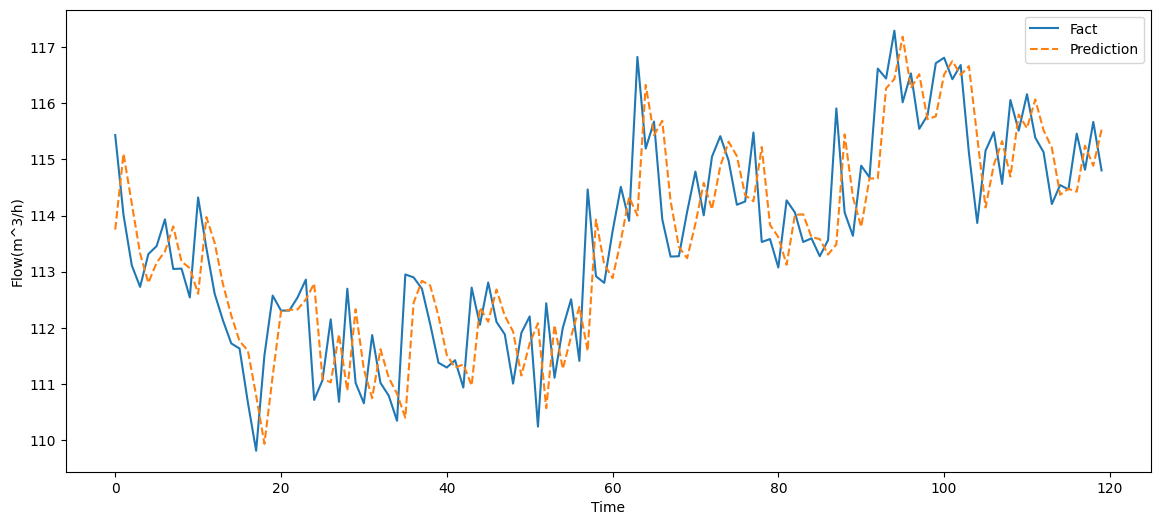

In [11]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

fig, ax = plt.subplots(figsize=(14, 6))
ax.set_xlabel('Time')
ax.set_ylabel('Flow(m^3/h)')
ax.plot(dataY_plot[-120:], label='Fact')
ax.plot(data_predict[-120:], linestyle='--', label='Prediction')
plt.legend()
plt.show()

训练

In [12]:
torch.save(lstm.state_dict(), "./output/model/flow_speed_rnn.pt")